In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import vaex

from astropy.io import fits
from astropy.stats import binned_binom_proportion
from astropy.wcs import WCS
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D
from m33_utils import open_and_select

np.seterr(all='ignore')

sns.set(style='ticks', 
        rc={'font.family'          : 'serif',
            'text.usetex'          : True,
            'axes.axisbelow'       : True,
            'mathtext.fontset'     : 'cm',
            'mathtext.default'     : 'regular',
            'xtick.direction'      : 'in',
            'ytick.direction'      : 'in',
            'xtick.major.width'    : 1.1,
            'ytick.major.width'    : 1.1,
            'axes.labelpad'        : 5.0,
            'legend.framealpha'    : 0.95,
            'legend.handlelength'  : 1.2,
            'legend.handletextpad' : 0.5,
       })

pal = sns.color_palette('colorblind')
dark = sns.color_palette('dark')
sns.set_palette(pal)

In [2]:
def myround(x, n=0.5):
    return np.round(x/n)*n

def add_colorbar(fig, ax, cmap='viridis', vmin=0, vmax=1,
                 norm='Normalize', n_colors=None,
                 offset=0.0175, width=0.0225, label='Density'):
    pos = ax.get_position()
    cax = fig.add_axes([pos.x1+offset, pos.y0, width, pos.height])
    cmap_mpl = plt.get_cmap(cmap, n_colors)
    norm_mpl = getattr(mpl.colors, norm)(vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_mpl, cmap=cmap_mpl),
                        cax=cax, label=label)
    return cbar

from m33_utils import open_and_select
def read_artstars(infile):
    ds = open_and_select(infile)
    ds['DPOS'] = ds['((X_OUT-X_IN)**2 + (Y_OUT-Y_IN)**2)**0.5']
    for f in ds.get_column_names(regex='F.*?W_IN'):
        filt = f.split('_')[0]
        ds.add_column(f'{filt}_DELTA', ds[f'{filt}_VEGA-{filt}_IN'].evaluate())
        selection = f'({filt}_GST) & (DPOS < 2) & (abs({filt}_DELTA) < 2)'
        ds.select(selection, name=f'{filt}_detected')
        is_detected = ds.evaluate_selection_mask(f'{filt}_detected').astype(int)
        ds.add_column(f'{filt}_DET', is_detected)
    return ds

def plot_completeness(ds, x0=17.75, x1=30.5, n=0.5, vmax_dict=None):
    x = np.arange(x0, x1, n)
    df_comp = pd.DataFrame(data=(x[:-1]+x[1:])/2, columns=['mag']).set_index('mag', drop=True)
    with sns.color_palette(sns.hls_palette(6, l=0.5)[::-1]):
        handles = []
        labels = ['F275W','F336W','F475W','F814W','F110W','F160W']
        fig, ax = plt.subplots(1, figsize=(6, 4))
        for i,c in enumerate(labels):
            comp_col = c
            vals, succ = ds[[f'{c}_IN', f'{c}_DET']].values.T
            vmax = vmax_dict[c] if (vmax_dict is not None) else x1
            good = vals < vmax
            succ = succ[good]
            vals = vals[good]
            bc, hw, p, perr = binned_binom_proportion(vals, succ, bins=x,
                                                      confidence_level=0.95,
                                                      interval='jeffreys')
            ptch = ax.fill_between(bc, p-perr[0], p+perr[1], alpha=0.3, zorder=-1)
            li, = ax.plot(bc, p, zorder=69-i)
            df_comp.loc[bc, comp_col] = p 
            s_interp = df_comp[comp_col].sort_values()
            c_interp = np.interp(0.5, s_interp.values, s_interp.index.values)
            df_comp.loc[c_interp, comp_col] = 0.5
            handles.append((ptch, li))
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(x0-0.5, x1+0.5)
    ax.axhline(0.5, color='k',ls='--')
    ax.legend(handles, labels, handlelength=1, loc='lower left',
              handler_map={tuple: HandlerTuple(ndivide=1)})
    ax.set_xlabel('Apparent magnitude (Vega)')
    ax.set_ylabel('Completeness fraction')
    return fig, ax, df_comp.sort_index().interpolate(method='index')

def plot_xy_delta(ds, uv_filt='F336W', opt_filt='F814W', ir_filt='F160W',
                  vmin=-2, vmax=2):
    fig, axes = plt.subplots(1, 3, figsize=(9, 6), sharey=True, sharex=True)
    extent = [*ds.minmax('X_IN'), *ds.minmax('Y_IN')]
    for ax, filt in zip(*[axes, [uv_filt, opt_filt, ir_filt]]):
        selection='(F814W_IN < 28)' if filt == 'F814W' else None
        med = ds.median_approx(f'{filt}_DELTA', binby=['Y_IN','X_IN'],
                               shape=(100, 76), limits='minmax',
                               selection=selection)
        ax.imshow(med, extent=extent, cmap='twilight_shifted',
                  vmin=vmin, vmax=vmax, origin='lower', aspect='equal')
        ax.set_title(filt)
        ax.set_xlabel('X')
    ax1, ax2, ax3 = axes
    ax1.set_ylabel('Y')
    ax1.set_yticklabels(ax1.get_yticks().astype(int))
    if ds.filename == '../artstars/M33_B01_SS_fake_final.hdf5':
        fig.tight_layout(w_pad=0.375, h_pad=0)
    else:
        fig.tight_layout(w_pad=1, h_pad=0)
    add_colorbar(fig, ax3, cmap='twilight_shifted', vmin=vmin, vmax=vmax,
                 label='Median $\Delta$mag (Measured--input)')
    return fig

In [3]:
filters = ['F275W', 'F336W', 'F475W', 'F814W', 'F110W', 'F160W']
density_tuples = [(0, 0.15), (0.15, 0.3), (0.3, 0.6), (0.6, 0.9), (0.9, 10)]

ds = read_artstars(glob.glob('../artstars/*_fake_final.hdf5'))
density_bin = np.zeros(ds.length())
for i, (d0, d1) in enumerate(density_tuples):
    ds.select(f'(DENSITY >= {d0}) & (DENSITY < {d1})', name=f'd{i}')
    density = ds.evaluate_selection_mask(f'd{i}')
    density_bin += density*(i+1)
ds.add_column('DENSITY_BIN', density_bin)

vmax_dict = {f : myround(ds.max(f'{f}_IN', selection=f'{f}_detected'))+0.5 for f in filters}
vmax_dict['F814W'] = 29

<string>:1: RuntimeWarning: invalid value encountered in less


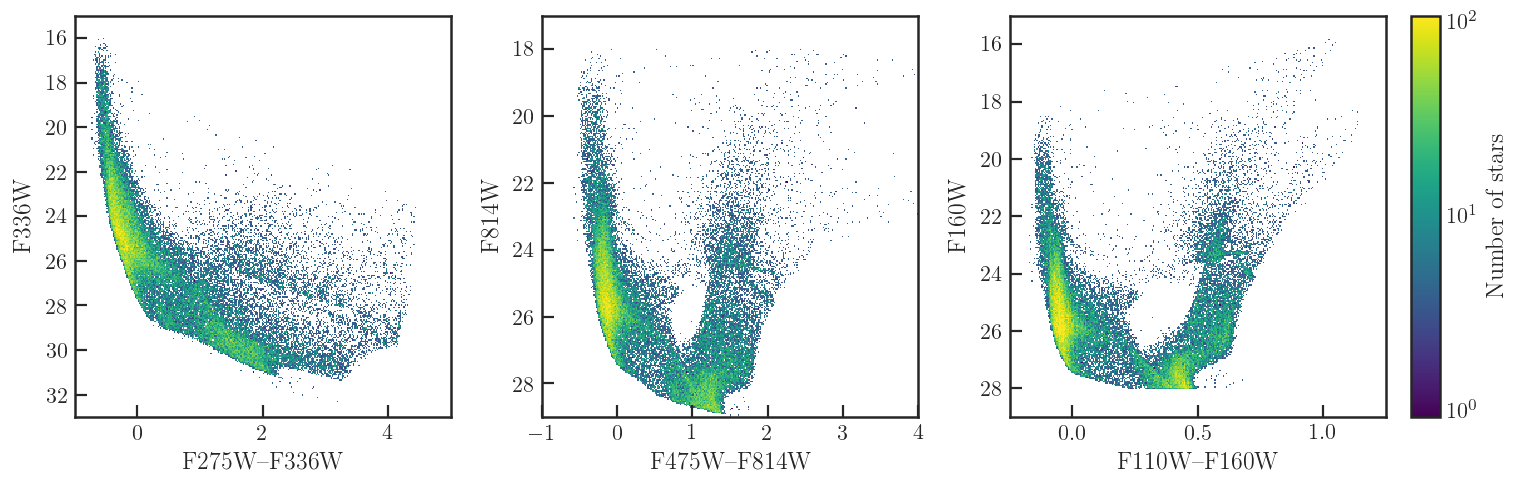

In [4]:
ds.plot([['F275W_IN-F336W_IN', 'F336W_IN'],
         ['F475W_IN-F814W_IN', 'F814W_IN'],
         ['F110W_IN-F160W_IN', 'F160W_IN']],
        limits=[[[-1, 5], [33, 15]], [[-1, 4], [29, 17]], [[-0.25, 1.25], [29, 15]]],
        f='log10', shape=300,
        xlabel=['F275W--F336W', 'F475W--F814W', 'F110W--F160W'],
        ylabel=['F336W', 'F814W', 'F160W'],
        colorbar=False, colormap='viridis', vmin=-0.03, vmax=2.03,
        figsize=(10, 3.6), tight_layout=True)
fig = plt.gcf()
axes = fig.get_axes()

cbar = add_colorbar(fig, axes[-1], cmap='viridis', vmin=10**-0.03, vmax=10**2.03, width=0.02, 
                    norm='LogNorm', label='Number of stars')
fig.savefig('survey_paper_figures/ast_input_CMDs.pdf', dpi=420, bbox_inches='tight')

,F275W,F336W,F475W,F814W,F110W,F160W
0.105,24.437384,25.632270,27.661104,26.788392,25.690087,25.032584
0.213,24.431379,25.531674,27.270269,26.522464,25.190216,24.661523
0.422,24.423103,25.543492,27.034614,26.224487,24.678706,23.992182
0.776,24.370055,25.435875,26.473538,25.774347,24.088723,23.380472
1.053,24.144580,25.102294,25.782018,25.388054,23.717902,23.042195


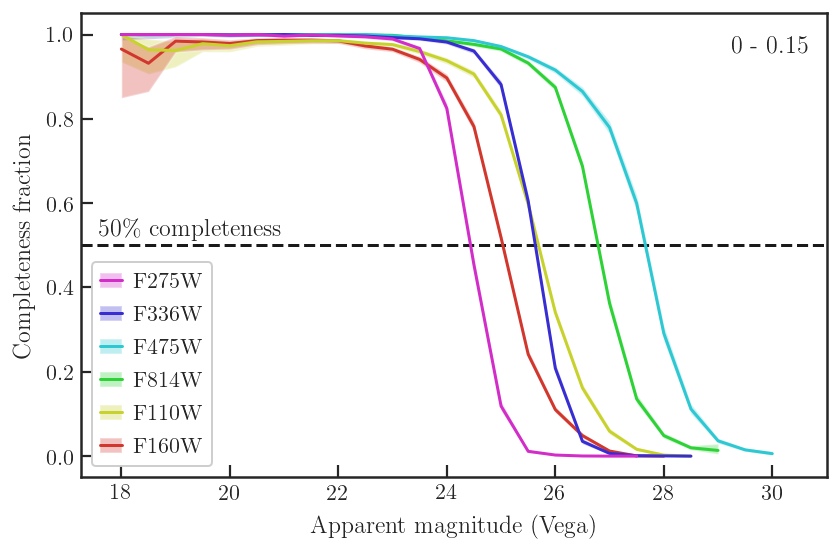

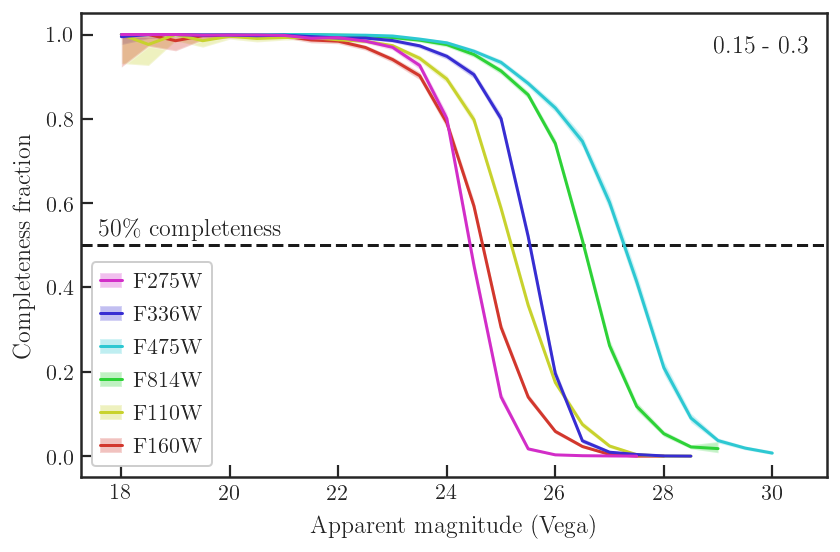

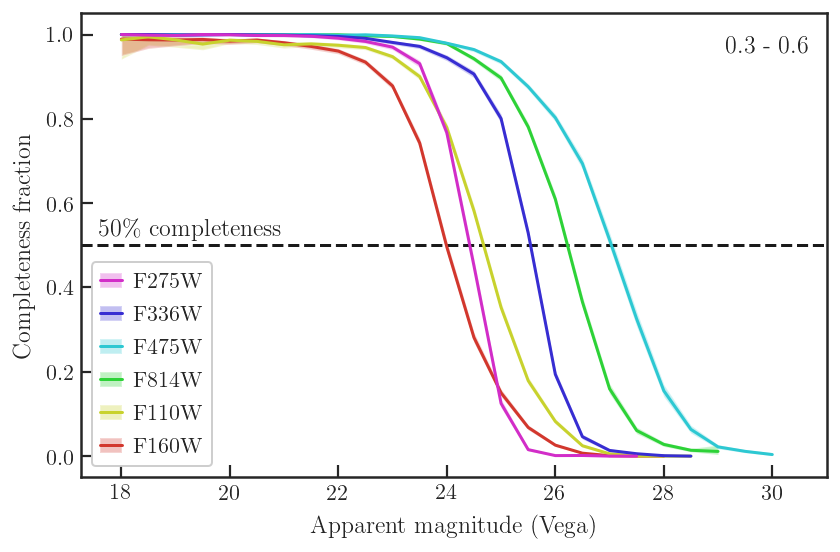

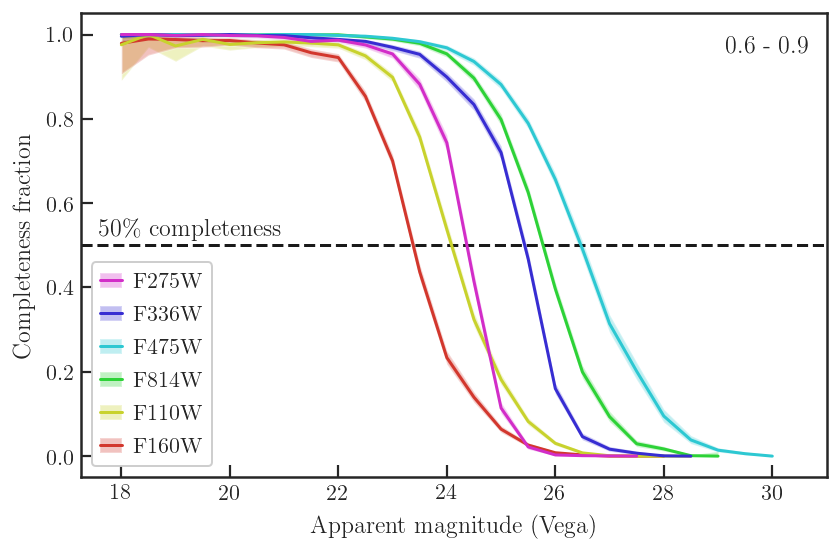

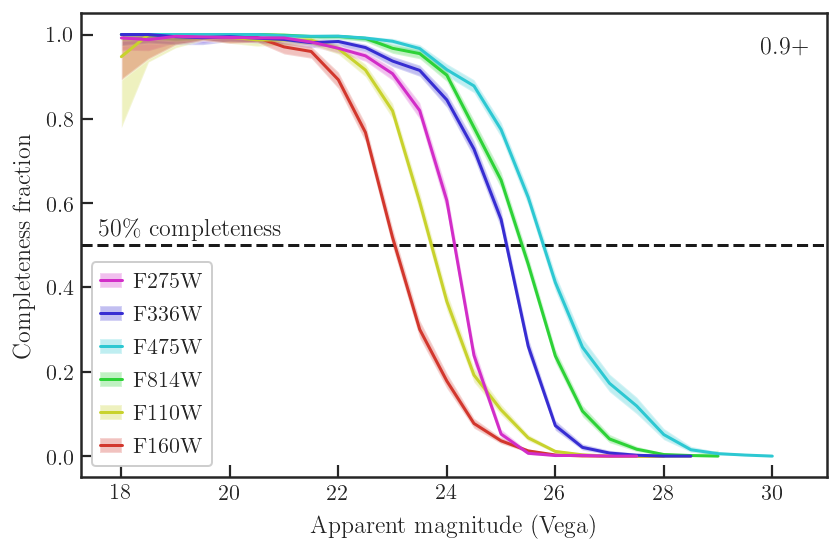

In [5]:
df_comp = pd.DataFrame(columns=filters, index=[1,2,3,4], data=np.nan)
for i, d in enumerate(density_tuples):
    fig, ax, comp = plot_completeness(ds[ds.DENSITY_BIN == i+1], vmax_dict=vmax_dict)
    for f in ['F275W','F336W','F475W','F814W','F110W','F160W']:
        p50_idx = (comp[f] - 0.5).abs().idxmin()
        df_comp.loc[i+1, f] = p50_idx
    txt = f'{d[0]} - {d[1]}' if (d[1] < 5) else f'{d[0]}+'
    ax.text(0.975, 0.95, txt, va='top', ha='right', transform=ax.transAxes)
    ax.text(0.025, 0.51, '50\% completeness', va='bottom', ha='left', transform=ax.transAxes)
    fig.tight_layout()
    fig.savefig(f'survey_paper_figures/density{i+1}_comp.pdf', bbox_inches='tight')
densities = ds.median_approx('DENSITY', binby='DENSITY_BIN', shape=len(density_tuples),
                             limits=[ds.min('DENSITY_BIN')-0.5, ds.max('DENSITY_BIN')+0.5],
                             percentile_shape=20000, percentile_limits='minmax')
df_comp.set_index(pd.Index(np.round(densities, 3)), inplace=True)
df_comp

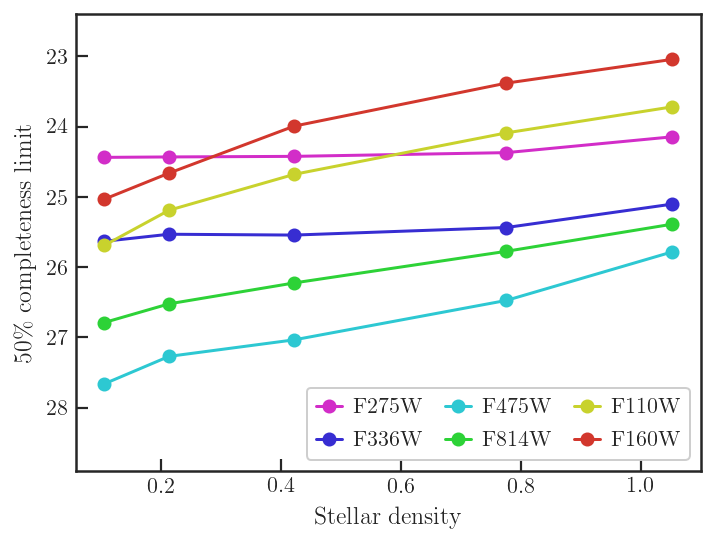

In [6]:
with sns.color_palette(sns.hls_palette(6, l=0.5)[::-1]):
    fig, ax = plt.subplots(1, figsize=(5.6, 4.2))
    df_comp[filters].plot(linestyle='-', marker='o', figure=fig, ax=ax, legend=False)
ax.set_ylim(28.9, 22.4)
ax.legend(ncol=3, columnspacing=1, loc='lower right')
ax.set_xlabel('Stellar density')
ax.set_ylabel('50\% completeness limit')
fig.savefig('survey_paper_figures/density_completeness_summary.pdf', bbox_inches='tight')

In [7]:
df_comp['bin_lo'] = [0, 0.15, 0.3, 0.6, 0.9]
df_comp['bin_hi'] = [0.15, 0.3, 0.6, 0.9, 10]
density_str = [f'{d[0]} - {d[1]}' if (d[1] < 10) else f'{d[0]}+' for d in density_tuples]
df_comp.set_index(pd.Index(density_str), inplace=True)
df_comp[filters].round(2).to_latex('../table_completeness.tex')

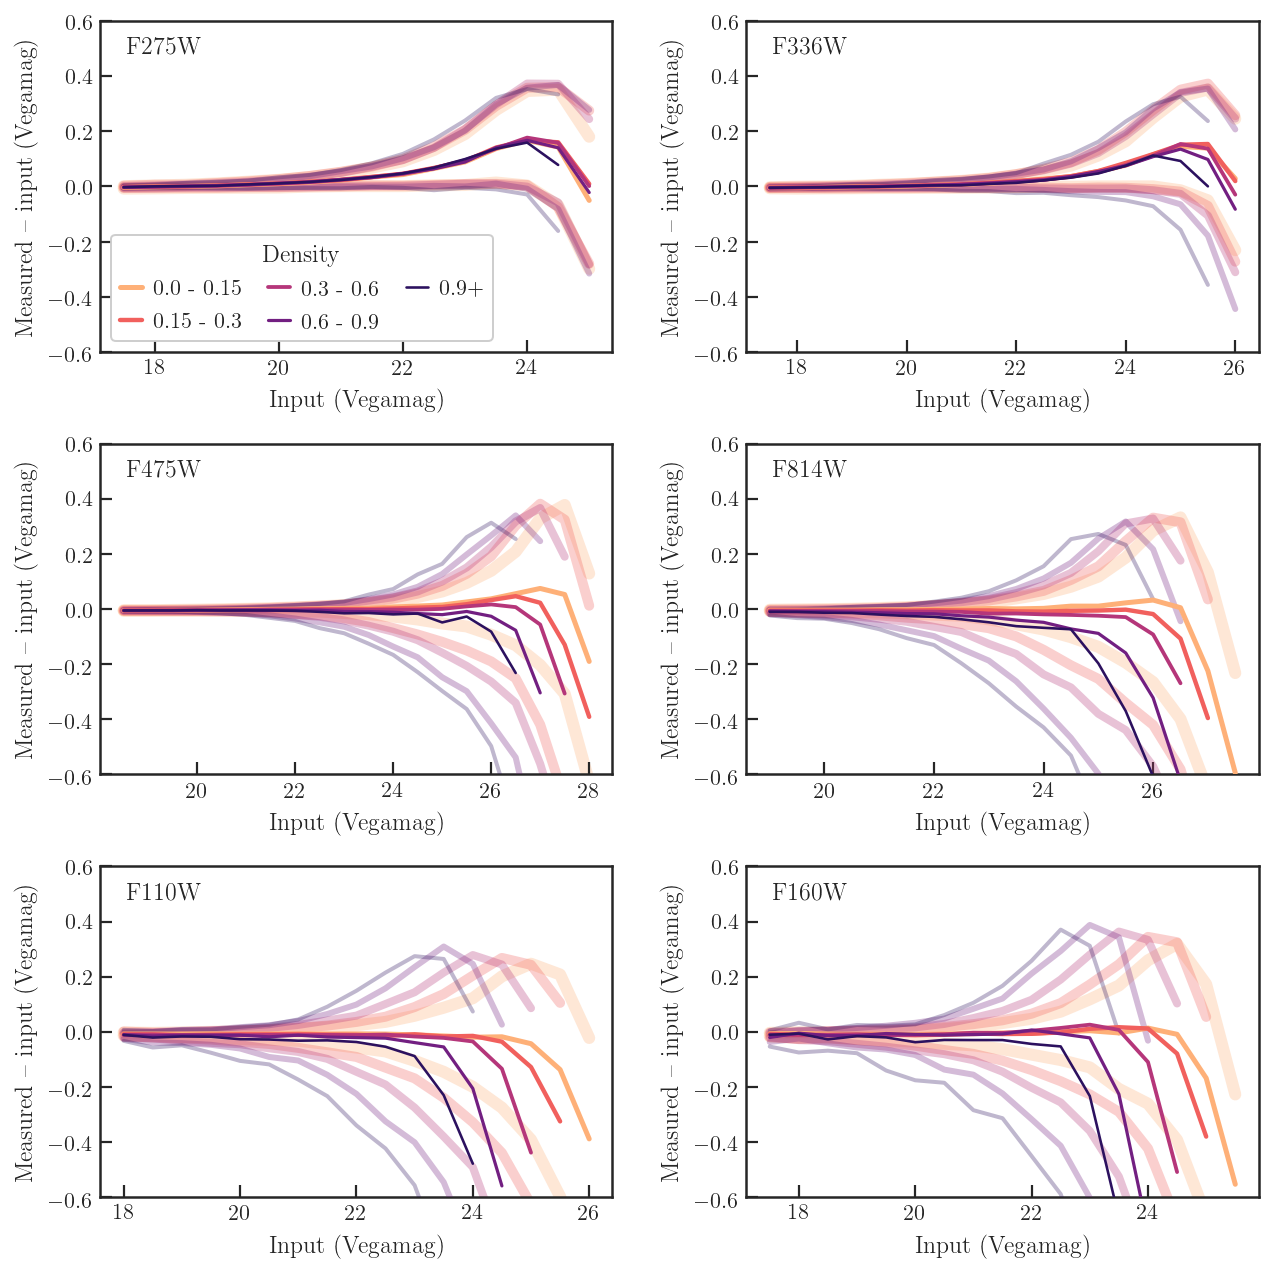

In [8]:
index = pd.MultiIndex.from_product([df_comp.index.values, filters, np.arange(16, 30, 0.5)],
                                   names=['Density', 'Filter', 'Magnitude'])
df_bias = pd.DataFrame(data=np.nan, index=index, columns=['Bias', 'Uncertainty', 'DOLPHOT', 'Ratio'])

pc_kwargs = dict(percentile_shape=10000, percentile_limits='minmax')

def plot_bias(ds, df_bias=df_bias, filters=filters, df_comp=df_comp.reset_index()):
    fig, axes = plt.subplots(3, 2, figsize=(9, 9))
    axes = axes.ravel()
    for i, filt in enumerate(filters):
        ax = axes[i]
        pmin = 0.3 if (filt in ['F160W', 'F336W']) else 0.5 if (filt in ['F275W','F110W']) else 5
        x0 = max(myround(ds.percentile_approx(f'{filt}_IN', pmin, selection=f'{filt}_detected')), 18)
        for j in df_comp.index.values:
            density = df_comp.loc[j, ['bin_lo','bin_hi']].values
            txt = f'{density[0]} - {density[1]}' if (density[1] < 5) else f'{density[0]}+'
            x = np.arange(x0-0.75, myround(df_comp.loc[j, filt])+1.25, 0.5)
            shape_kwargs = dict(limits=[x.min(), x.max()], shape=len(x)-1)
            mask = ds.evaluate_selection_mask(f'({filt}_detected) & (DENSITY_BIN == {j+1})')
            ds.add_column(f'{filt}_{j}', mask)
            ds_ = ds[ds[f'{filt}_{j}'] == 1].extract()
            bc = ds_.bin_centers(f'{filt}_IN', **shape_kwargs)
            p16, p50, p84 = ds_.percentile_approx(f'{filt}_DELTA', [16, 50, 84], 
                                                  binby=f'{filt}_IN', #selection=f'{filt}_sc',
                                                  **pc_kwargs, **shape_kwargs)
            l0, = ax.plot(bc, p50, lw=2.5-(0.3*j), zorder=1000+j, label=txt)
            ax.plot(bc, p16, alpha=0.3, lw=6-j, color=l0.get_color(), zorder=j)
            ax.plot(bc, p84, alpha=0.3, lw=6-j, color=l0.get_color(), zorder=j)
            dol = ds_.median_approx(f'{filt}_ERR', binby=f'{filt}_IN',
                                    **pc_kwargs, **shape_kwargs)
            df_bias.loc[(df_comp.loc[j, 'index'], filt, bc), 'Bias'] = p50
            df_bias.loc[(df_comp.loc[j, 'index'], filt, bc), 'Uncertainty'] = (p84 - p16) / 2
            df_bias.loc[(df_comp.loc[j, 'index'], filt, bc), 'DOLPHOT'] = dol
        ax.set_ylim(-0.6, 0.6)
        ax.set_xlabel(f'Input (Vegamag)')
        ax.set_ylabel(f'Measured -- input (Vegamag)')
        if filt == 'F275W':
            ax.legend(loc='lower left', ncol=3, handlelength=1,
                      columnspacing=1.2, title='Density')
        ax.text(0.05, 0.95, filt, ha='left', va='top',
                transform=ax.transAxes)
    fig.tight_layout(w_pad=2, h_pad=1)
    return fig

with sns.color_palette(sns.color_palette('magma_r', 11)[1::2]):
    fig = plot_bias(ds)
fig.savefig('survey_paper_figures/ast_bias_uncertainty.pdf', bbox_inches='tight')

In [9]:
df_bias['Ratio'] = df_bias['Uncertainty']/df_bias['DOLPHOT']
df_bias = df_bias.dropna(subset=['Bias','Uncertainty'])
f275w_idx = df_bias.loc[(density_str[0], 'F275W')].copy().reset_index().index
df_bias.reset_index().iloc[f275w_idx].to_latex('../table_bias.tex', index=False)

/astro/users/mdurbin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
# df_bias.groupby(['Filter']).agg({'Ratio':'median'}).round(1)
# df_bias['BU'] = df_bias['Bias'].abs() / df_bias['Uncertainty']
# df_bias.groupby(['Filter']).agg({'BU':'median'}).round(1)

,Ratio
Filter,
F110W,5.3
F160W,6.6
F275W,1.2
F336W,1.3
F475W,4.4
F814W,5.6
